In [1]:
from src.net.model import ViTSTRTransducer
from src.data import Vocabulary, ImageStatistics, Transforms
import logging
import torch
import numpy as np
from PIL import Image
logging.basicConfig(level=logging.INFO)

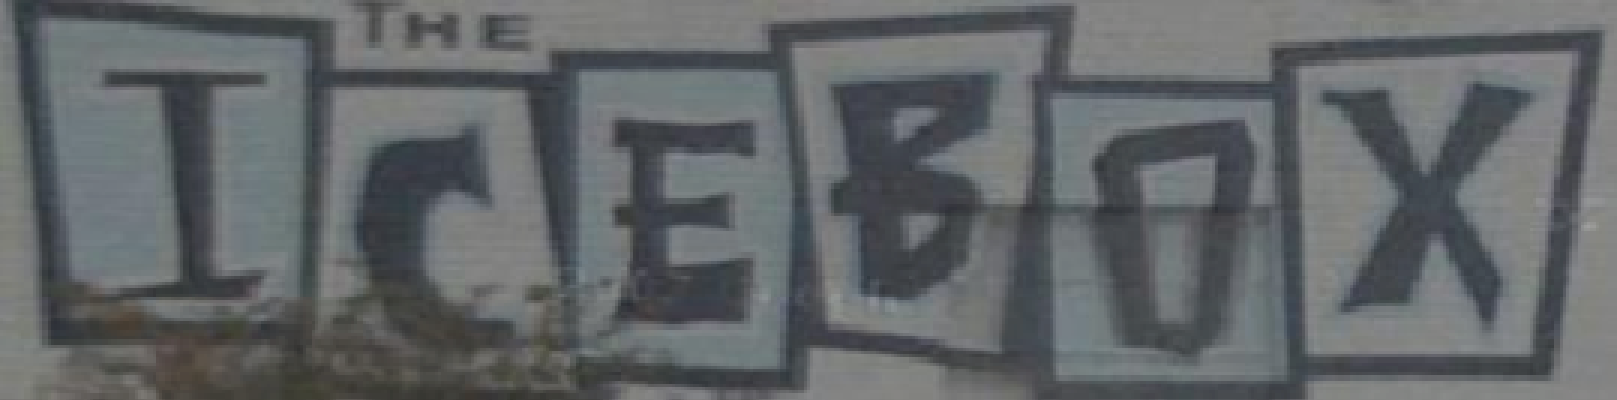

In [2]:
input_size = (112, 448)
input_channels = 3

transforms = Transforms(input_size, mean=ImageStatistics.MEAN_RGB, std=ImageStatistics.STD_RGB).eval

labels = r"!%&,-./0123456789=_abcdefghijklmnopqrstuvwxyz"
vocab = Vocabulary(labels)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

path_to_image = 'imgs/raw_img_example/image.png'
raw_img = Image.open(path_to_image).convert('RGB') # or 'L' if input_channels is 1
image_as_array = np.array(raw_img) # (H, W, C)
raw_img

# PyTorch model (FP32 / FP16 / BF16)
## Single image

In [3]:
pt_model = ViTSTRTransducer.load_from_checkpoint(
    checkpoint_path='ViTSTR-FP32.ckpt',
    map_location=device, 
    vocab=vocab, 
    training=False
).eval()
pt_model.freeze()

preprocessed_inputs = transforms(image=image_as_array)['image'].to(device=device).to(dtype=pt_model.dtype).unsqueeze(0) # (1, C, H, W)
pred, conf = pt_model.predict(preprocessed_inputs)
print(f"Preprocessed inputs shape:\n{preprocessed_inputs.shape}\n")
print(f"Predicted text:\n{pred[0]}\n")
print(f"Confidence score for every character:\n{conf[0]}")

Preprocessed inputs shape:
torch.Size([1, 3, 112, 448])

Predicted text:
icebox

Confidence score for every character:
tensor([0.2306, 0.9142, 0.4998, 0.4960, 0.9550, 0.8603])


## Batch

In [4]:
images_batch = np.stack([image_as_array]*3, axis=0) # (3, H, W, C): 3 same images for example

preprocessed_inputs = [transforms(image=image)['image'].to(device=device).to(dtype=pt_model.dtype) for image in images_batch]
preprocessed_inputs = torch.stack(preprocessed_inputs) # (3, C, H, W)


pred, conf = pt_model.predict(preprocessed_inputs)
print(f"Preprocessed inputs shape:\n{preprocessed_inputs.shape}\n")
print(f"[BATCH] Predicted text:\n{pred}\n")
print(f"[BATCH] Confidence score for every character:\n{conf}")

Preprocessed inputs shape:
torch.Size([3, 3, 112, 448])

[BATCH] Predicted text:
['icebox', 'icebox', 'icebox']

[BATCH] Confidence score for every character:
[tensor([0.2306, 0.9142, 0.4998, 0.4960, 0.9550, 0.8603]), tensor([0.2306, 0.9142, 0.4998, 0.4960, 0.9550, 0.8603]), tensor([0.2306, 0.9142, 0.4998, 0.4960, 0.9550, 0.8603])]


# TorchScript model (FP16 / BF16)

In [ ]:
ts_model = ImageCaptionerTorchscript(
    checkpoint_path='ViTSTR-BF16.torchscript', 
    labels=r"!%&,-./0123456789=_abcdefghijklmnopqrstuvwxyz",
    device=device,
    dtype=torch.bfloat16
)
processed_img = ts_model.preprocess_image(path_to_image)
output = ts_model.predict(processed_img)
print(output)

INFO:src.image_captioner:Inference time: 0.37 seconds


icebox
